# <center> </center>
# <center> 7b. VAR Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['tsDyn', 'vars']
RPY.load_R_packages(R_packages)

R packages loaded: tsDyn, vars


Load Python libraries

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
import warnings; warnings.filterwarnings("ignore")

# 1. Data


In [5]:
url = 'http://www.freddiemac.com/fmac-resources/research/docs/fmhpi_master_file.csv'
storage_options = {'User-Agent': 'Mozilla/5.0'}
data = pd.read_csv(url, storage_options=storage_options)

In [6]:
LA = "Los Angeles-Long Beach-Anaheim CA"
RI = "Riverside-San Bernardino-Ontario CA"

HPI_LA = data[data['GEO_Name'] == LA].copy()
HPI_LA['date'] = pd.to_datetime(HPI_LA['Year'].astype(str) + '-' + HPI_LA['Month'].astype(str) + '-01')
HPI_LA = HPI_LA.set_index('date')['Index_NSA'].rename('LA')

HPI_RI = data[data['GEO_Name'] == RI].copy()
HPI_RI['date'] = pd.to_datetime(HPI_RI['Year'].astype(str) + '-' + HPI_RI['Month'].astype(str) + '-01')
HPI_RI = HPI_RI.set_index('date')['Index_NSA'].rename('RI')

HPI = pd.concat([HPI_LA, HPI_RI], axis=1)

Plot the data

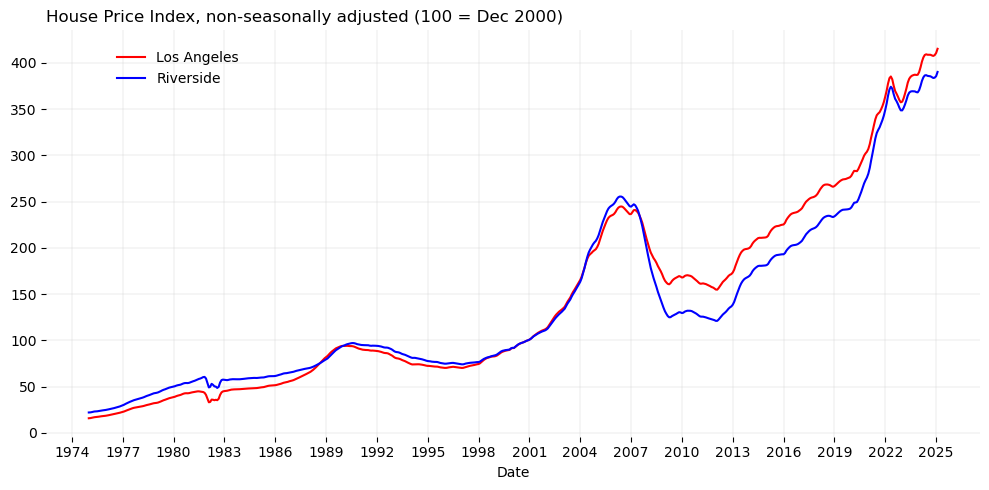

In [7]:
colors = {"Los Angeles": "red", "Riverside": "blue"}

plt.figure(figsize=(10, 5))
plt.plot(HPI.index, HPI["LA"], color=colors["Los Angeles"], label="Los Angeles")
plt.plot(HPI.index, HPI["RI"], color=colors["Riverside"], label="Riverside")
plt.xlabel('Date')
plt.ylabel('')
plt.title("House Price Index, non-seasonally adjusted (100 = Dec 2000)", loc='left')
plt.legend(loc=(0.07, 0.85), frameon=False)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(3))
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.tight_layout()
plt.show()

Plot the differenced data

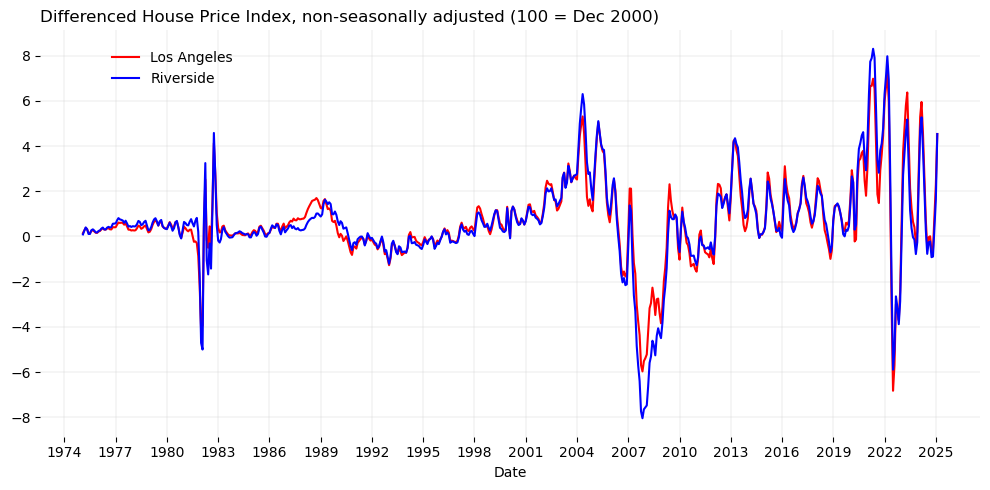

In [8]:
D_HPI = HPI.diff().dropna()
D_HPI.index.freq = 'MS'

colors = {"Los Angeles": "red", "Riverside": "blue"}

plt.figure(figsize=(10, 5))
plt.plot(D_HPI.index, D_HPI["LA"], color=colors["Los Angeles"], label="Los Angeles")
plt.plot(D_HPI.index, D_HPI["RI"], color=colors["Riverside"], label="Riverside")
plt.xlabel('Date')
plt.ylabel('')
plt.title("Differenced House Price Index, non-seasonally adjusted (100 = Dec 2000)", loc='left')
plt.legend(loc=(0.07, 0.85), frameon=False)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(3))
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.tight_layout()
plt.show()

# 2. VAR Estimation

Using level data and the option `I="diff"` will automatically difference the data, use the differences to estimate the parameters, forecast differences, and automatically add them to output forecasts of level data.

In [9]:
ro.globalenv['HPI'] = HPI # copy data from Python to R
ro.globalenv['D_HPI'] = D_HPI

In [10]:
%%R
VAR_model <- tsDyn::lineVar(data=HPI, lag=4, model="VAR", I="diff")
VAR_model$coefficients

           [,1]      [,2]       [,3]       [,4]       [,5]      [,6]
 0.09055538 2.4117348 -0.6491513 -2.1079277  0.6503674 0.9703097
 0.07223529 0.8300814  0.9289056 -0.8514207 -0.5814385 0.0124337
            [,7]       [,8]       [,9]
 -0.07212948 -0.5308341  0.2074300
  0.88239510 -0.1413879 -0.1779105


# 3. Granger Causality Test
Test H0 of no Granger causality

In [11]:
%%R
VAR_vars <- vars::VAR(y=D_HPI, p=4)
vars::causality(VAR_vars, cause = "LA")$Granger


	Granger causality H0: LA do not Granger-cause RI

data:  VAR object VAR_vars
F-Test = 12.218, df1 = 4, df2 = 1176, p-value = 9.778e-10



In [12]:
%%R
vars::causality(VAR_vars, cause = "RI")$Granger


	Granger causality H0: RI do not Granger-cause LA

data:  VAR object VAR_vars
F-Test = 10.223, df1 = 4, df2 = 1176, p-value = 3.878e-08



# 4. Impulse-response Function
Impulse-response function: LA => Riverside

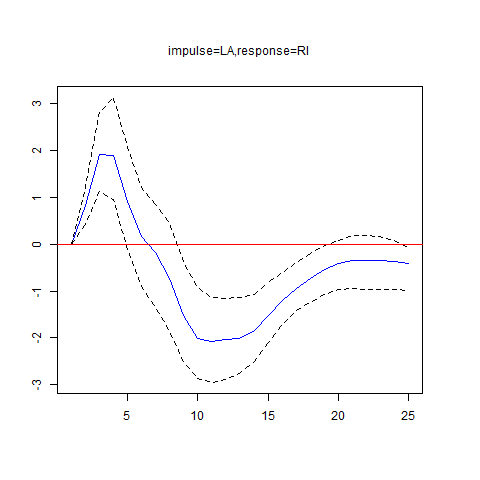

In [13]:
%%R
irf1 <- vars::irf(VAR_vars, impulse = "LA", response = "RI", n.ahead = 24, ortho=FALSE)
plot(irf1,sub="",main="impulse=LA,response=RI",col=c("blue", "black", "black"), mar=c(0,0,0,0))

# 5. Forecast

Forecast with VAR 

In [14]:
%%R
h_steps <- 6 # forecast horizon
VAR_f <- stats::predict(VAR_model, n.ahead=h_steps) 

In [15]:
h_steps = int(ro.globalenv['h_steps'][0])
VAR_f = ro.globalenv['VAR_f'] 
VAR_forecast = pd.DataFrame(VAR_f, columns=['LA','RI'])
id = HPI.index  
id_f = pd.date_range(start=id[-1], periods=h_steps, freq="M")
VAR_forecast.index = id_f

Plot

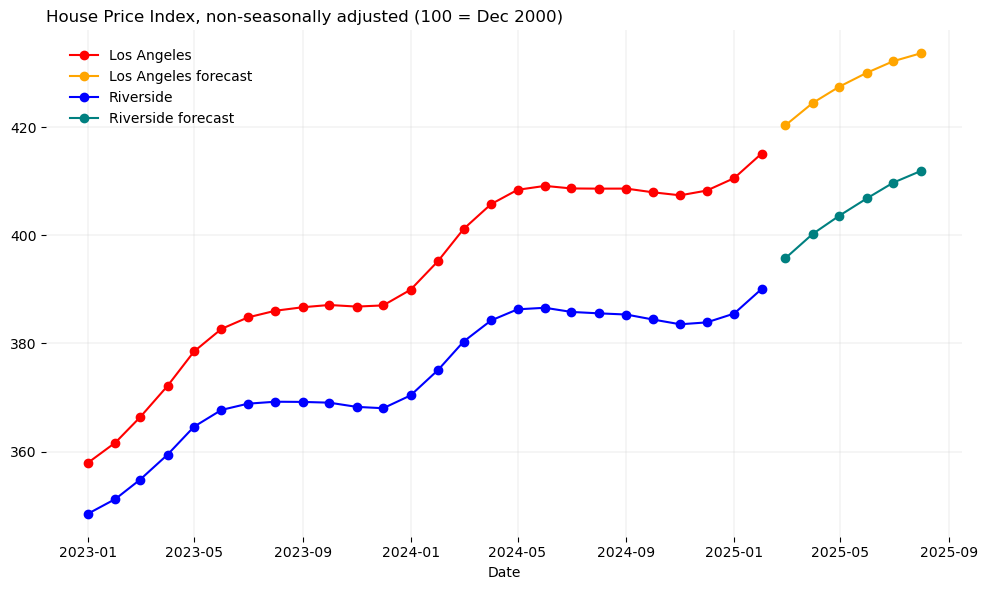

In [16]:
start_plot = pd.to_datetime('2023-01-01')
HPI_s = HPI[HPI.index >= start_plot]

colors = {"Los Angeles": "red", "Los Angeles forecast": "orange",
          "Riverside": "blue", "Riverside forecast": "teal"}

plt.figure(figsize=(10, 6))
plt.plot(HPI_s.index, HPI_s["LA"], color=colors["Los Angeles"], 
         label="Los Angeles", linestyle='-', marker='o')
plt.plot(VAR_forecast.index, VAR_forecast["LA"], color=colors["Los Angeles forecast"], 
         label="Los Angeles forecast", linestyle='-', marker='o')
plt.plot(HPI_s.index, HPI_s["RI"], color=colors["Riverside"], 
         label="Riverside", linestyle='-', marker='o')
plt.plot(VAR_forecast.index, VAR_forecast["RI"], color=colors["Riverside forecast"], 
         label="Riverside forecast", linestyle='-', marker='o')
plt.xlabel('Date')
plt.ylabel('')
plt.title("House Price Index, non-seasonally adjusted (100 = Dec 2000)", loc='left')
plt.legend(loc=(0.02, 0.8), frameon=False)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(1))
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.tight_layout()
plt.show()